<a href="https://colab.research.google.com/github/kuhu42/credit-card-fraud/blob/main/basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection in Credit Card Transaction Data using Machine Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## About the Dataset

#### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

#### Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

#### Acknowledgement
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

Please cite the following works:

Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019

Yann-Aël Le Borgne, Gianluca Bontempi Reproducible machine Learning for Credit Card Fraud Detection - Practical Handbook

Bertrand Lebichot, Gianmarco Paldino, Wissam Siblini, Liyun He, Frederic Oblé, Gianluca Bontempi Incremental learning strategies for credit cards fraud detection, IInternational Journal of Data Science and Analytics

## Analysis, Basic Training and CV

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_auc_score, confusion_matrix, make_scorer, mean_squared_error, r2_score, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

#### LOADING THE DATASET

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')

##### BASIC EDA

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.isna().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


#### **Exploring the features**

##### Visualizing the distribution of 'Amount'

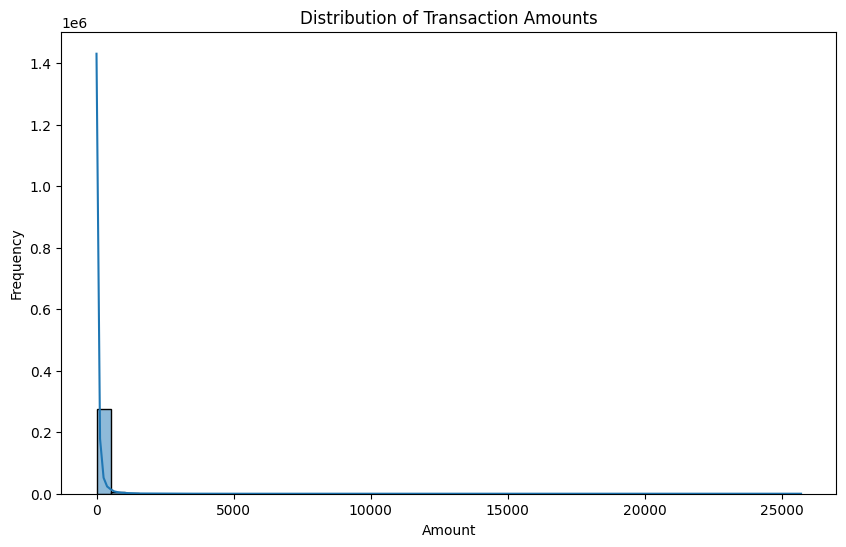

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

#### Visualizing the distribution of 'Time'

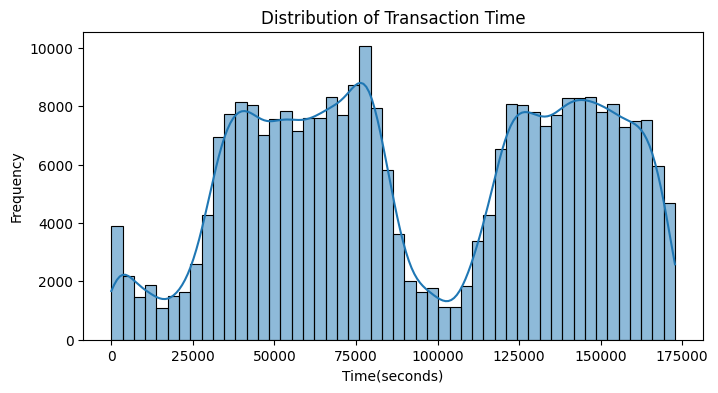

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df['Time'], bins=50, kde=True)
plt.title('Distribution of Transaction Time')
plt.xlabel('Time(seconds)')
plt.ylabel('Frequency')
plt.show()

#### **Correlation Matrix of PCA components**

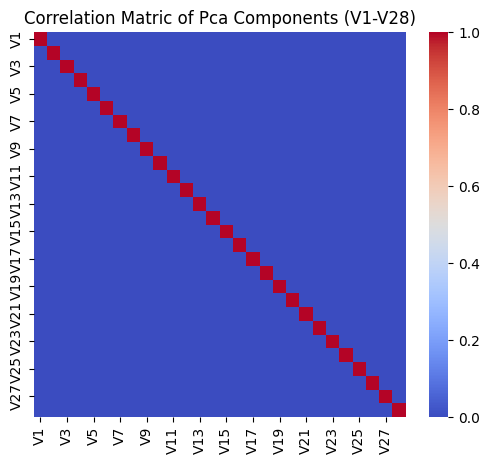

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(df.iloc[:, 1:29].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Matric of Pca Components (V1-V28)")
plt.show()

#### **Addressing Class Imbalance**

In [ ]:
df['Class'].value_counts(normalize=True) * 100

,proportion
Class,
0,99.827251
1,0.172749


Applying SMOTE (Synthetic Minority Over Sampling) to balance the Classes

*Explanation: In our dataset the fraudulent classes are naturally substantially less than the non-fraudulent classes. This is because in the real world banking transactions frauds are a rarity. This can cause the machine learning model to become biased and cause the model to predict the majority classes more frequently which can be incorrect more often than not.*

In [ ]:

df = df.dropna(subset=['Class'])

x = df.drop('Class', axis=1)
y = df['Class']
if x.isna().sum().sum() > 0:
    x = x.fillna(0)
if y.isna().sum() > 0:
    raise ValueError("Target variable contains NaNs. Please handle them before resampling.")

sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x, y)

print(f'Original dataset shape: {x.shape}')
print(f'Resampled dataset shape: {x_res.shape}')


Original dataset shape: (284807, 30)
Resampled dataset shape: (568630, 30)


#### **Feature Engineering**

Log-transforming the 'Amount' Feature

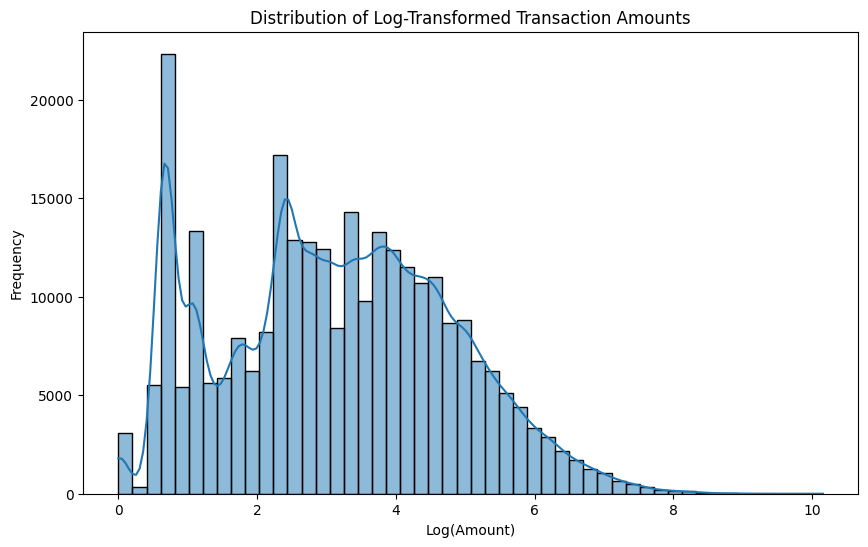

In [ ]:
df['LogAmount'] = np.log1p(df['Amount'])

plt.figure(figsize=(10, 6))
sns.histplot(df['LogAmount'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Transaction Amounts')
plt.xlabel('Log(Amount)')
plt.ylabel('Frequency')
plt.show()

Adding Hour of the Day from 'Time'

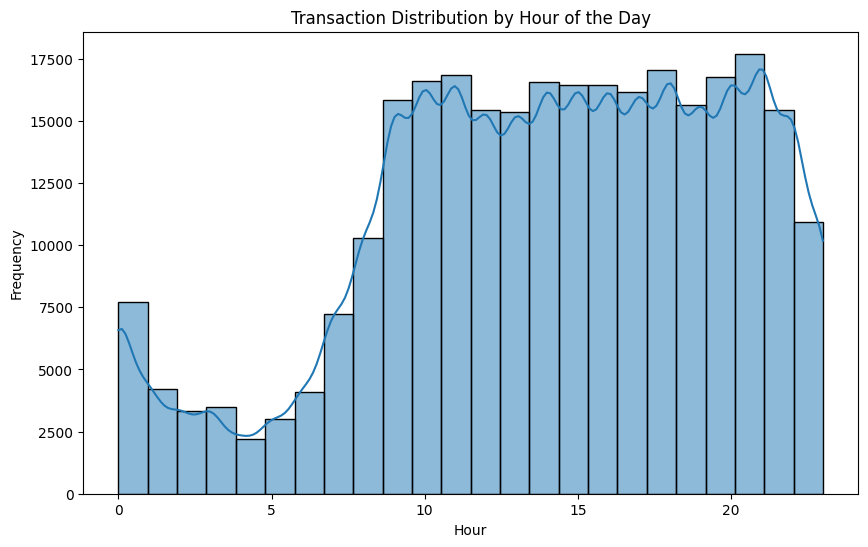

In [ ]:
df['Hour'] = (df['Time'] // 3600) % 24

plt.figure(figsize=(10, 6))
sns.histplot(df['Hour'], bins=24, kde=True)
plt.title('Transaction Distribution by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()

#### **k-Fold Cross-Validation**

In [ ]:

x_res = np.array(x_res)
y_res = np.array(y_res)

# Define the number of folds
k = 5

# Create a pipeline with standardization and the RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),            # Standardize the data
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))  # RandomForest model
])

# Initialize k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define a scorer to use for evaluation
scorer = make_scorer(roc_auc_score)

# Perform k-fold cross-validation
cv_results = []
for train_index, test_index in kf.split(x_res):  # Make sure to use `test_index` here
    X_train_cv, X_test_cv = x_res[train_index], x_res[test_index]
    y_train_cv, y_test_cv = y_res[train_index], y_res[test_index]

    # Fit the model
    pipeline.fit(X_train_cv, y_train_cv)

    # Predict probabilities for the test set
    y_probs_cv = pipeline.predict_proba(X_test_cv)[:, 1]

    # Evaluate the model
    score = roc_auc_score(y_test_cv, y_probs_cv)
    cv_results.append(score)

# Print the cross-validation results
print(f"Cross-validation scores: {cv_results}")
print(f"Mean AUC score: {np.mean(cv_results):.4f}")


Cross-validation scores: [0.9999894412609931, 0.9999813494690346, 0.9999996748005965, 0.9999981632322072, 0.9999984155963463]
Mean AUC score: 1.0000


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
df.head()

In [ ]:
X = df.drop(columns=['Class'])  # 'Class' is your target for logistic regression
y_logistic = df['Class']  # For Logistic Regression (Binary target)
y_linear = df['LogAmount']  # For Linear Regression (you can choose other continuous variables)

# Split dataset into training and testing sets (for both logistic and linear regression)
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_logistic, test_size=0.2, random_state=42)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X, y_linear, test_size=0.2, random_state=42)

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train_lin, y_train_lin)

In [ ]:
y_pred_lin = linear_model.predict(X_test_lin)

In [ ]:
mse = mean_squared_error(y_test_lin, y_pred_lin)
r2 = r2_score(y_test_lin, y_pred_lin)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Linear regression R-squared (R^2): {r2}")

In [ ]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train_log)

In [ ]:
y_pred_log = logistic_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test_log, y_pred_log)
conf_matrix = confusion_matrix(y_test_log, y_pred_log)
class_report = classification_report(y_test_log, y_pred_log)

print(f'Logistic Regression Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')